# Imports

In [1]:
import copy


import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import (
    BoxStyle, 
    ConnectionPatch, 
    FancyBboxPatch, 
    Rectangle
)
from pymer4.models import Lmer
from pymer4.utils import _get_params, _sig_stars
from rpy2 import robjects
from scipy.stats import chi2
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR,
    DATA_DIR,
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import disable_logging, reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def lrt(*models, refit=True):
    """
    Compute a likelihood-ratio test between two (or more) `pymer4.Lmer` 
    models. Equivalent to running `anova(mod1, mod2, ...)` in R.
    
    This is a tweaked reimplementation of `pymer4.stats.lrt` that fixes 
    a bug in p-value calculations. See
    https://github.com/ejolly/pymer4/issues/134
    """
    if len(models) < 2:
        raise ValueError("Must pass at least 2 Lmer models")
    if not all(isinstance(mod, Lmer) for mod in models):
        raise TypeError("All models must by instances of pymer4.Lmer")
    
    models_list = list(models)
    show_refit_msg = False
    
    if refit:
        for i, mod in enumerate(models):
            if mod._REML:
                show_refit_msg = True
                mod_refit = copy.deepcopy(mod)
                mod_refit.fit(REML=False, summarize=False)
                models_list[i] = mod_refit
        if show_refit_msg:
            print("refitting model(s) with ML (instead of REML)")
    
    # reorder models based on number of parameters (fewest -> most)
    all_params = np.array([_get_params(m) for m in models_list])
    idx = all_params.argsort()
    all_params = all_params[idx]
    models_list = np.array(models_list)[idx]
    
    output_df = pd.DataFrame(index=range(len(models_list)), 
                             columns=('model', 'npar', 'AIC', 'BIC', 
                                      'log-likelihood', 'deviance', 'Chisq', 
                                      'Df', 'P-val', 'Sig'))
    for i, mod in enumerate(models_list):
        npar = _get_params(mod)
        if i > 0:
            df = npar - _get_params(models_list[i - 1])
            chisq = -2 * (models_list[i - 1].logLike - mod.logLike)
            pval = chi2.sf(chisq, df)
        else:
            df = np.nan
            chisq = np.nan
            pval = np.nan
        output_df.loc[i] = [mod.formula, npar, mod.AIC, mod.BIC, mod.logLike, 
                            -2 * mod.logLike, chisq, df, pval, _sig_stars(pval)]
    
    return output_df.fillna('')

In [3]:
def format_stats(odds_ratio, lrt, p_val):
    OR_fmt = f'OR = {odds_ratio:.3f}'
    lrt_fmt = f'$\lambda_{{LR}}$ = {lrt:.3f}'
    
    if p_val < 0.001:
        pval_fmt = '$p$ < 0.001'
    else:
        pval_fmt = f'$p$ = {p_val:.3f}'
        
    return f'{OR_fmt}\n{lrt_fmt}\n{pval_fmt}'

In [4]:
def annotate_textbox(
    annot_str, 
    annot_xy, 
    text_pad=0, 
    rounded=False,
    rounding_size=0.05,
    blur=False,
    blur_size=0.05,
    blur_n_steps=10,
    ax=None, 
    annot_kwargs=None,
    rect_kwargs=None
):    
    ax = ax or plt.gca()
    annot_kwargs = annot_kwargs or {}
    rect_kwargs = rect_kwargs or {}
    textbox_max_alpha = rect_kwargs.pop('alpha', 1)
    rect_kwargs.setdefault('linewidth', 0)
    rect_kwargs.setdefault('edgecolor', None)
    
    if rounded:
        RectCls = FancyBboxPatch
        annot_boxstyle = BoxStyle.Round(pad=text_pad, rounding_size=rounding_size)
    else:
        RectCls = Rectangle
        annot_boxstyle = BoxStyle.Square(pad=text_pad)
    
    # add text annotation
    annot_obj = ax.annotate(annot_str, 
                            xy=annot_xy, 
                            bbox={'boxstyle': annot_boxstyle, 
                                  'alpha': textbox_max_alpha,
                                  **rect_kwargs}, 
                            **annot_kwargs)
    
    if blur:
        # draw figure to set bbox coordinates
        ax.get_figure().canvas.draw()
        # get textbox patch object and bounding box
        annot_bbox_patch = annot_obj.get_bbox_patch()
        annot_bbox = annot_bbox_patch.get_extents().transformed(ax.transData.inverted())
        
        bbox_x0, bbox_y0, bbox_width, bbox_height = annot_bbox.bounds

        blur_pads = np.linspace(0, blur_size, blur_n_steps+1, endpoint=True)[1:]
        
        for i, pad in enumerate(blur_pads[::-1]):
            blurred_bbox = FancyBboxPatch(xy=(bbox_x0-pad, bbox_y0-pad), 
                                          width=bbox_width+(2*pad), 
                                          height=bbox_height+(2*pad),
                                          boxstyle=annot_boxstyle,
                                          alpha=textbox_max_alpha*i/(len(blur_pads)-1),
                                          transform=ax.transAxes,
                                          edgecolor=None,
                                          linewidth=0,
                                          zorder=annot_obj.get_zorder()-0.1,
                                          **rect_kwargs)
            ax.add_patch(blurred_bbox)

# Collect data for analyses

In [5]:
exp = Experiment()

CONDITIONS = ['all_questions', 'lec1_within', 'lec2_within', 'lec1_across', 'lec2_across']

In [6]:
datalist = []

pbar = tqdm(total=len(exp.all_data), leave=False)

for quiz_n in range(1, 4):
    for p in exp.participants:
        # participant ID
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz_n-1)
        
        for target_question_row in quiz_data.itertuples():
            if target_question_row.qID == 38:
                pbar.update()
                continue
            
            # target question
            target_question_id = target_question_row.qID
            target_question_acc = target_question_row.accuracy
            target_question_lec = target_question_row.lecture
            target_question_vec = exp.question_vectors[target_question_id - 1]
            
            if target_question_lec == 1:
                target_question_lec_str = 'Forces'
            elif target_question_lec == 2:
                target_question_lec_str = 'BoS'
            else:
                target_question_lec_str = 'general'
            
            # all other questions on same quiz
            other_questions_rows = quiz_data.drop(
                index=target_question_row.Index
            ).reset_index(drop=True)
            
            # if at least one held-in question has opposite 
            # "accuracy" label of held-out question, rebalancing 
            # is possible for "all questions" conditions
            opp_acc_ixs = np.flatnonzero(
                other_questions_rows['accuracy'] != target_question_acc
            )
            if len(opp_acc_ixs) > 0:
                # iteratively hold out each opposite-label question and
                # estimate knowledge for target question using all others
                rebalanced_knowledge_estimates = []
                for ix in opp_acc_ixs:
                    other_questions_rows_rebalanced = other_questions_rows.drop(index=ix)
                    other_questions_acc_rebalanced = other_questions_rows_rebalanced['accuracy']
                    other_questions_vecs_rebalanced = exp.question_vectors[
                        other_questions_rows_rebalanced['qID'] - 1
                    ]
                    k_est_rebalanced = reconstruct_trace(target_question_vec[None, :], 
                                                         other_questions_vecs_rebalanced, 
                                                         other_questions_acc_rebalanced).item()
                    rebalanced_knowledge_estimates.append(k_est_rebalanced)
                # use average of rebalanced knowledge estimates as 
                # knowledge estimate for held-out question
                knowledge_estimate_all = np.mean(rebalanced_knowledge_estimates)
            
                if target_question_lec == 0:
                    # exclude general knowledge questions from 
                    # within-lecture estimates
                    knowledge_estimate_same = np.nan
                else:
                    # questions about same lecture as target question
                    same_lecture_rows = other_questions_rows.loc[
                        other_questions_rows['lecture'] == target_question_lec
                    ].reset_index(drop=True)
                    opp_acc_ixs = np.flatnonzero(same_lecture_rows['accuracy'] != target_question_acc)
                    if len(opp_acc_ixs) > 0:
                        # rebalance as above
                        rebalanced_knowledge_estimates = []
                        for ix in opp_acc_ixs:
                            same_lecture_rows_rebalanced = same_lecture_rows.drop(index=ix)
                            same_lecture_acc_rebalanced = same_lecture_rows_rebalanced['accuracy']
                            same_lecture_vecs_rebalanced = exp.question_vectors[
                                same_lecture_rows_rebalanced['qID'] - 1
                            ]
                            k_est_rebalanced = reconstruct_trace(target_question_vec[None, :], 
                                                                 same_lecture_vecs_rebalanced, 
                                                                 same_lecture_acc_rebalanced).item()
                            rebalanced_knowledge_estimates.append(k_est_rebalanced)
                        knowledge_estimate_same = np.mean(rebalanced_knowledge_estimates)
                    else:
                        # rebalancing is not possible
                        knowledge_estimate_same = np.nan
            else:
                # rebalancing is not possible for "all questions" or 
                # "within-lecture" conditions
                knowledge_estimate_all = np.nan
                knowledge_estimate_same = np.nan
            
            if target_question_lec == 0:
                # exclude general knowledge questions from 
                # across-lecture estimates
                knowledge_estimate_other = np.nan
            else:
                # questions about opposite lecture from target question
                opp_lecture = (not target_question_lec - 1) + 1
                opp_lecture_rows = other_questions_rows.loc[
                    other_questions_rows['lecture'] == opp_lecture
                ].reset_index(drop=True)
                opp_lecture_vecs = exp.question_vectors[opp_lecture_rows['qID'] - 1]
                opp_lecture_acc = opp_lecture_rows['accuracy']
                # target question's label is independent of held-in 
                # questions' labels, so rebalancing isn't necessary
                knowledge_estimate_other = reconstruct_trace(target_question_vec[None, :], 
                                                             opp_lecture_vecs, 
                                                             opp_lecture_acc).item()
    
            datalist.append({
                'quiz': f'Quiz{quiz_n}',
                'qID': f'Q{target_question_id}',
                'participant_id': subid,
                'lecture': target_question_lec_str,
                'accuracy': 'correct' if target_question_acc == 1 else 'incorrect',
                'knowledge_all': knowledge_estimate_all,
                'knowledge_same': knowledge_estimate_same, 
                'knowledge_other': knowledge_estimate_other
            })
            pbar.update()    
pbar.close()

lme_data = pd.DataFrame(datalist).astype({
    # convert to categorical dtype so R treats variables as factors
    'quiz': pd.CategoricalDtype(categories=('Quiz1', 'Quiz2', 'Quiz3'), ordered=True),
    'qID': 'category',
    'participant_id': 'category',
    'lecture': 'category',
    'accuracy': pd.CategoricalDtype(categories=('incorrect', 'correct'))
})

lme_data.head()

  0%|          | 0/1950 [00:00<?, ?it/s]

,quiz,qID,participant_id,lecture,accuracy,knowledge_all,knowledge_same,knowledge_other
0,Quiz1,Q13,P1,Forces,correct,0.339949,0.503572,0.355440
1,Quiz1,Q21,P1,BoS,incorrect,0.588033,0.342637,1.000000
2,Quiz1,Q12,P1,Forces,incorrect,0.491695,0.365400,0.641186
3,Quiz1,Q16,P1,BoS,correct,0.539077,1.000000,0.356176
4,Quiz1,Q28,P1,BoS,correct,0.326643,0.021762,0.853083


In [7]:
quiz1_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz1']
quiz2_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz2']
quiz3_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz3']

models = {f'quiz{i}': {cond: {} for cond in CONDITIONS} for i in range(1, 4)}

# All questions

## Quiz 1

In [8]:
quiz1_allqs_data = quiz1_lme_data.loc[~quiz1_lme_data['knowledge_all'].isna()]

mod = Lmer('accuracy ~ knowledge_all + (1|lecture) + (1+knowledge_all|lecture:qID)',
           data=quiz1_allqs_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|lecture) + (1+knowledge_all|lecture:qID)',
                data=quiz1_allqs_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -383.505 	 AIC: 779.011

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  1.609  1.269
lecture:qID  knowledge_all  2.991  1.729
lecture        (Intercept)  0.157  0.397

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.535

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.189,-1.931,-0.448,0.378,0.304,0.145,0.639,0.233,0.127,0.390,-3.145,0.002,**
knowledge_all,2.095,1.174,3.016,0.470,8.126,3.235,20.412,0.890,0.764,0.953,4.458,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -392.006 	 AIC: 794.012

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  1.744  1.321
lecture:qID  knowledge_all  7.591  2.755
lecture        (Intercept)  0.175  0.418

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.644

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.426,-1.112,0.261,0.35,0.653,0.329,1.298,0.395,0.247,0.565,-1.215,0.224,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|lecture)+(1+knowledge_all|lecture:...,5,794.012322,816.280447,-392.006161,784.012322,,,,
1,accuracy~knowledge_all+(1|lecture)+(1+knowledg...,6,779.010711,805.732461,-383.505356,767.010711,17.001611,1,0.000037,***


## Quiz 2

In [9]:
quiz2_allqs_data = quiz2_lme_data.loc[~quiz2_lme_data['knowledge_all'].isna()]

mod = Lmer('accuracy ~ knowledge_all + (1|lecture) + (1+knowledge_all|lecture:qID)',
           data=quiz2_allqs_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|lecture) + (1+knowledge_all|lecture:qID)',
                data=quiz2_allqs_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 622	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -332.701 	 AIC: 677.402

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  3.184  1.784
lecture:qID  knowledge_all  3.085  1.756
lecture        (Intercept)  1.028  1.014

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.869

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.052,-2.454,0.350,0.715,0.349,0.086,1.418,0.259,0.079,0.587,-1.471,0.141,
knowledge_all,2.702,1.687,3.716,0.518,14.902,5.403,41.100,0.937,0.844,0.976,5.219,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 622	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -345.405 	 AIC: 700.810

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  7.511  2.741
lecture:qID  knowledge_all  9.560  3.092
lecture        (Intercept)  1.074  1.036

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.956

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.98,-0.313,2.273,0.66,2.664,0.731,9.704,0.727,0.422,0.907,1.485,0.137,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|lecture)+(1+knowledge_all|lecture:...,5,700.810025,722.974726,-345.405013,690.810025,,,,
1,accuracy~knowledge_all+(1|lecture)+(1+knowledg...,6,677.401529,703.999169,-332.700764,665.401529,25.408496,1,0.0,***


## Quiz 3

In [10]:
quiz3_allqs_data = quiz3_lme_data.loc[~quiz3_lme_data['knowledge_all'].isna()]

mod = Lmer('accuracy ~ knowledge_all + (1+knowledge_all||lecture:qID)',
           data=quiz3_allqs_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_all||lecture:qID)',
                data=quiz3_allqs_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1+knowledge_all||lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 581	 Groups: {'lecture:qID': 38.0}

Log-likelihood: -268.961 	 AIC: 545.923

Random effects:

                        Name    Var    Std
lecture.qID      (Intercept)  1.756  1.325
lecture.qID.1  knowledge_all  0.358  0.598

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.336,-2.305,-0.367,0.494,0.263,0.100,0.693,0.208,0.091,0.409,-2.702,0.007,**
knowledge_all,3.622,2.464,4.779,0.591,37.409,11.756,119.040,0.974,0.922,0.992,6.133,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_all||lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 581	 Groups: {'lecture:qID': 38.0}

Log-likelihood: -289.436 	 AIC: 584.871

Random effects:

                        Name    Var    Std
lecture.qID      (Intercept)  0.438  0.662
lecture.qID.1  knowledge_all  2.186  1.478

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.99,0.232,1.749,0.387,2.692,1.261,5.749,0.729,0.558,0.852,2.558,0.011,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_all||lecture:qID),3,584.871175,597.965428,-289.435588,578.871175,,,,
1,accuracy~knowledge_all+(1+knowledge_all||lectu...,4,545.922794,563.381797,-268.961397,537.922794,40.948382,1,0.0,***


# Within-lecture

## Quiz 1

### Lecture 1 given lecture 1

In [11]:
quiz1_lec1_within_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'Forces') & 
    (~quiz1_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz1_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz1_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 230	 Groups: {'qID': 15.0}

Log-likelihood: -117.718 	 AIC: 241.435

Random effects:

            Name    Var    Std
qID  (Intercept)  2.551  1.597

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.579,-2.564,-0.595,0.502,0.206,0.077,0.552,0.171,0.072,0.355,-3.145,0.002,**
knowledge_same,2.768,1.827,3.710,0.480,15.934,6.216,40.847,0.941,0.861,0.976,5.764,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 230	 Groups: {'qID': 15.0}

Log-likelihood: -138.203 	 AIC: 280.407

Random effects:

            Name    Var    Std
qID  (Intercept)  1.836  1.355

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.381,-1.139,0.376,0.387,0.683,0.32,1.457,0.406,0.243,0.593,-0.987,0.324,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,280.406581,287.282740,-138.203290,276.406581,,,,
1,accuracy~knowledge_same+(1|qID),3,241.435307,251.749545,-117.717654,235.435307,40.971274,1,0.0,***


### Lecture 2 given lecture 2

In [12]:
quiz1_lec2_within_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'BoS') & 
    (~quiz1_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same|qID)',
           data=quiz1_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_same|qID)',
                data=quiz1_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same|qID)

Family: binomial	 Inference: parametric

Number of observations: 215	 Groups: {'qID': 15.0}

Log-likelihood: -125.363 	 AIC: 260.726

Random effects:

               Name    Var    Std
qID     (Intercept)  0.793  0.891
qID  knowledge_same  1.113  1.055

             IV1             IV2   Corr
qID  (Intercept)  knowledge_same -0.307

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.195,-1.857,-0.532,0.338,0.303,0.156,0.587,0.232,0.135,0.370,-3.536,0.0,***
knowledge_same,2.280,1.232,3.328,0.535,9.775,3.427,27.884,0.907,0.774,0.965,4.263,0.0,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_same|qID)

Family: binomial	 Inference: parametric

Number of observations: 215	 Groups: {'qID': 15.0}

Log-likelihood: -132.325 	 AIC: 272.650

Random effects:

               Name    Var    Std
qID     (Intercept)  0.810  0.900
qID  knowledge_same  7.382  2.717

             IV1             IV2   Corr
qID  (Intercept)  knowledge_same -0.415

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.775,-1.711,0.162,0.478,0.461,0.181,1.176,0.315,0.153,0.54,-1.621,0.105,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_same|qID),4,272.649817,286.132369,-132.324908,264.649817,,,,
1,accuracy~knowledge_same+(1+knowledge_same|qID),5,260.725926,277.579116,-125.362963,250.725926,13.923891,1,0.00019,***


## Quiz 2

### Lecture 1 given lecture 1

In [13]:
quiz2_lec1_within_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'Forces') & 
    (~quiz2_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz2_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz2_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 155	 Groups: {'qID': 15.0}

Log-likelihood: -73.752 	 AIC: 153.505

Random effects:

            Name    Var    Std
qID  (Intercept)  3.356  1.832

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.521,-2.927,-0.116,0.717,0.218,0.054,0.891,0.179,0.051,0.471,-2.121,0.034,*
knowledge_same,3.559,2.062,5.056,0.764,35.126,7.858,157.023,0.972,0.887,0.994,4.658,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 155	 Groups: {'qID': 15.0}

Log-likelihood: -89.878 	 AIC: 183.756

Random effects:

            Name    Var    Std
qID  (Intercept)  1.672  1.293

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.798,0.015,1.581,0.399,2.222,1.015,4.86,0.69,0.504,0.829,1.998,0.046,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,183.756000,189.842850,-89.878000,179.756000,,,,
1,accuracy~knowledge_same+(1|qID),3,153.504747,162.635022,-73.752373,147.504747,32.251253,1,0.0,***


### Lecture 2 given lecture 2

In [14]:
quiz2_lec2_within_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'BoS') & 
    (~quiz2_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz2_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz2_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 220	 Groups: {'qID': 15.0}

Log-likelihood: -135.911 	 AIC: 277.822

Random effects:

            Name    Var    Std
qID  (Intercept)  0.451  0.672

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.042,-1.583,-0.501,0.276,0.353,0.205,0.606,0.261,0.170,0.377,-3.775,0.0,***
knowledge_same,1.551,0.783,2.319,0.392,4.717,2.188,10.169,0.825,0.686,0.910,3.957,0.0,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 220	 Groups: {'qID': 15.0}

Log-likelihood: -144.305 	 AIC: 292.610

Random effects:

            Name    Var    Std
qID  (Intercept)  0.386  0.621

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.477,-0.904,-0.05,0.218,0.621,0.405,0.951,0.383,0.288,0.488,-2.188,0.029,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,292.610274,299.397529,-144.305137,288.610274,,,,
1,accuracy~knowledge_same+(1|qID),3,277.822029,288.002911,-135.911014,271.822029,16.788245,1,0.000042,***


## Quiz 3

### Lecture 1 given lecture 1

In [15]:
quiz3_lec1_within_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'Forces') & 
    (~quiz3_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz3_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz3_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 190	 Groups: {'qID': 15.0}

Log-likelihood: -93.467 	 AIC: 192.934

Random effects:

            Name    Var    Std
qID  (Intercept)  3.446  1.856

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.547,-0.844,1.938,0.710,1.728,0.430,6.943,0.633,0.301,0.874,0.771,0.441,
knowledge_same,0.910,-0.312,2.132,0.624,2.485,0.732,8.435,0.713,0.423,0.894,1.460,0.144,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 190	 Groups: {'qID': 15.0}

Log-likelihood: -94.459 	 AIC: 192.919

Random effects:

            Name    Var    Std
qID  (Intercept)  3.237  1.799

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.241,0.214,2.268,0.524,3.46,1.239,9.664,0.776,0.553,0.906,2.369,0.018,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,192.918724,199.412772,-94.459362,188.918724,,,,
1,accuracy~knowledge_same+(1|qID),3,192.934308,202.675380,-93.467154,186.934308,1.984416,1,0.158926,


### Lecture 2 given lecture 2

In [16]:
quiz3_lec2_within_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'BoS') & 
    (~quiz3_lme_data['knowledge_same'].isna())
]
mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz3_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz3_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 150	 Groups: {'qID': 15.0}

Log-likelihood: -79.454 	 AIC: 164.907

Random effects:

            Name   Var    Std
qID  (Intercept)  1.39  1.179

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.199,-2.364,-0.034,0.594,0.301,0.094,0.966,0.232,0.086,0.491,-2.017,0.044,*
knowledge_same,2.827,1.532,4.122,0.661,16.902,4.629,61.709,0.944,0.822,0.984,4.279,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 150	 Groups: {'qID': 15.0}

Log-likelihood: -91.070 	 AIC: 186.140

Random effects:

            Name    Var    Std
qID  (Intercept)  0.801  0.895

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.853,0.247,1.458,0.309,2.346,1.281,4.299,0.701,0.562,0.811,2.761,0.006,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,186.139885,192.161155,-91.069942,182.139885,,,,
1,accuracy~knowledge_same+(1|qID),3,164.907253,173.939159,-79.453626,158.907253,23.232632,1,0.000001,***


# Across-lecture

## Quiz 1

### Lecture 1 given lecture 2

In [17]:
quiz1_lec1_across_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'Forces') &
    (~quiz1_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other|qID)',
           data=quiz1_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1+knowledge_other|qID)',
                data=quiz1_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -144.051 	 AIC: 300.103

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.030  0.173
qID                 (Intercept)  0.779  0.883
qID             knowledge_other  3.423  1.850

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other  0.757

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.788,-1.452,-0.124,0.339,0.455,0.234,0.883,0.313,0.190,0.469,-2.326,0.020,*
knowledge_other,0.640,-0.745,2.024,0.706,1.896,0.475,7.569,0.655,0.322,0.883,0.906,0.365,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -144.407 	 AIC: 298.815

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.031  0.177
qID                 (Intercept)  0.754  0.869
qID             knowledge_other  4.509  2.123

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other  0.628

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.76,-1.446,-0.074,0.35,0.468,0.235,0.928,0.319,0.191,0.481,-2.173,0.03,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1+knowledge_other...,5,298.814868,316.422172,-144.407434,288.814868,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,6,300.102642,321.231408,-144.051321,288.102642,0.712225,1,0.398706,


### Lecture 2 given lecture 1

In [18]:
quiz1_lec2_across_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'BoS') &
    (~quiz1_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other|qID)',
           data=quiz1_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1+knowledge_other|qID)',
                data=quiz1_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -157.896 	 AIC: 327.793

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.359  0.599
qID                 (Intercept)  1.737  1.318
qID             knowledge_other  3.837  1.959

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other -0.883

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.829,-1.711,0.053,0.450,0.437,0.181,1.055,0.304,0.153,0.513,-1.841,0.066,.
knowledge_other,0.420,-1.081,1.921,0.766,1.522,0.339,6.826,0.604,0.253,0.872,0.549,0.583,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -158.039 	 AIC: 326.079

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.374  0.611
qID                 (Intercept)  1.741  1.319
qID             knowledge_other  4.201  2.050

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other -0.881

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.632,-1.131,-0.132,0.255,0.532,0.323,0.876,0.347,0.244,0.467,-2.48,0.013,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1+knowledge_other...,5,326.078922,343.686227,-158.039461,316.078922,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,6,327.792716,348.921482,-157.896358,315.792716,0.286206,1,0.592662,


## Quiz 2

### Lecture 1 given lecture 2

In [19]:
quiz2_lec1_across_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'Forces') &
    (~quiz2_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1|qID)',
           data=quiz2_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz2_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -116.055 	 AIC: 240.111

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  1.509  1.229
qID             (Intercept)  2.012  1.418

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.461,0.343,2.580,0.571,4.312,1.409,13.201,0.812,0.585,0.930,2.560,0.010,*
knowledge_other,1.250,-0.097,2.597,0.687,3.490,0.907,13.426,0.777,0.476,0.931,1.818,0.069,.




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -117.688 	 AIC: 241.376

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  1.905  1.380
qID             (Intercept)  2.025  1.423

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.014,0.969,3.058,0.533,7.49,2.635,21.29,0.882,0.725,0.955,3.778,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,241.376286,251.940669,-117.688143,235.376286,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,4,240.110734,254.196578,-116.055367,232.110734,3.265552,1,0.070749,.


### Lecture 2 given lecture 1

In [20]:
quiz2_lec2_across_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'BoS') &
    (~quiz2_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1|qID)',
           data=quiz2_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz2_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -159.525 	 AIC: 327.050

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.023  0.153
qID             (Intercept)  0.367  0.606

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.227,-2.121,-0.333,0.456,0.293,0.120,0.717,0.227,0.107,0.417,-2.691,0.007,**
knowledge_other,0.788,-0.201,1.777,0.504,2.199,0.818,5.909,0.687,0.450,0.855,1.562,0.118,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -160.677 	 AIC: 327.354

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.149  0.385
qID             (Intercept)  0.376  0.613

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.613,-1.047,-0.178,0.222,0.542,0.351,0.837,0.351,0.26,0.456,-2.765,0.006,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,327.353577,337.917959,-160.676788,321.353577,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,4,327.049546,341.135390,-159.524773,319.049546,2.30403,1,0.129039,


## Quiz 3

### Lecture 1 given lecture 2

In [21]:
quiz3_lec1_across_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'Forces') &
    (~quiz3_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (0+knowledge_other|participant_id) + (1+knowledge_other||qID)',
           data=quiz3_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (0+knowledge_other|participant_id) + (1+knowledge_other||qID)',
                data=quiz3_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(0+knowledge_other|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -110.873 	 AIC: 231.747

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  0.475  0.689
qID                 (Intercept)  3.245  1.801
qID.1           knowledge_other  0.441  0.664

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.110,-1.642,1.421,0.781,0.895,0.194,4.142,0.472,0.162,0.806,-0.141,0.888,
knowledge_other,2.424,0.697,4.152,0.881,11.294,2.008,63.533,0.919,0.668,0.985,2.751,0.006,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(0+knowledge_other|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -116.071 	 AIC: 240.143

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  0.427  0.653
qID                 (Intercept)  2.772  1.665
qID.1           knowledge_other  0.452  0.673

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.602,0.243,2.962,0.694,4.964,1.275,19.331,0.832,0.56,0.951,2.31,0.021,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(0+knowledge_other|participant_id)+(1...,4,240.142743,254.228587,-116.071372,232.142743,,,,
1,accuracy~knowledge_other+(0+knowledge_other|pa...,5,231.746531,249.353836,-110.873266,221.746531,10.396212,1,0.001263,**


### Lecture 2 given lecture 1

In [22]:
quiz3_lec2_across_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'BoS') &
    (~quiz3_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (0+knowledge_other|qID)',
           data=quiz3_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (0+knowledge_other|qID)',
                data=quiz3_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(0+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -114.493 	 AIC: 236.987

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.665  0.815
qID             knowledge_other  1.742  1.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.317,-0.990,1.623,0.667,1.372,0.371,5.071,0.578,0.271,0.835,0.475,0.635,
knowledge_other,1.988,0.246,3.730,0.889,7.302,1.279,41.679,0.880,0.561,0.977,2.237,0.025,*




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(0+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -116.847 	 AIC: 239.695

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  1.096  1.047
qID             knowledge_other  1.881  1.371

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.719,0.91,2.527,0.413,5.577,2.484,12.518,0.848,0.713,0.926,4.166,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(0+knowledge_other...,3,239.694988,250.259371,-116.847494,233.694988,,,,
1,accuracy~knowledge_other+(1|participant_id)+(0...,4,236.986947,251.072790,-114.493473,228.986947,4.708042,1,0.030022,*


# Run parametric bootstrap for LRT

In [23]:
N_BOOTS = 10_000
GLMM_BOOTS_DIR = DATA_DIR.joinpath('GLMM-bootstraps')

In [24]:
# # NOTE: this takes a very long time to run in the Docker container. To 
# # reproduce this output, it may be more tractible to reconstruct the 
# # conda environment locally to take full advantage of parallelization
# pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

# for quiz_n in range(1, 4):
#     for cond in CONDITIONS:
#         boot_filepath = str(GLMM_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        
#         model = models[f'quiz{quiz_n}'][cond]['mod']
#         null_model = models[f'quiz{quiz_n}'][cond]['null_mod']
        
#         robjects.globalenv['model'] = model.model_obj
#         robjects.globalenv['null_model'] = null_model.model_obj
        
#         robjects.r(
#             f"""
#             set.seed(0)
#             cl <- parallel::makeCluster(5)    # must be an even divisor of N_BOOTS
#             lrt_null_dist <- pbkrtest::PBrefdist(model, null_model, nsim = {N_BOOTS}, seed = 123, cl = cl)
#             parallel::stopCluster(cl)
#             write.csv(as.vector(lrt_null_dist), {boot_filepath}, row.names = FALSE)
#             """
#         )
#         pbar.update()
        
# pbar.close()

In [25]:
for quiz_n in range(1, 4):
    print(f'Quiz {quiz_n}:')
    for cond in CONDITIONS:
        print(f'\t{cond}:')
        lrt_observed = models[f'quiz{quiz_n}'][cond]['lrt'].loc[1, 'Chisq']
        boot_filepath = str(GLMM_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        lrt_boots = pd.read_csv(boot_filepath).squeeze().to_numpy()
        # compute bootstrapped p-value for LRT statistic.
        # adapted from https://github.com/hojsgaard/pbkrtest/blob/3d22c5d/R/PB-modcomp.R
        lrt_boots_pos = lrt_boots[lrt_boots > 0]
        p_boot = ((lrt_boots_pos > lrt_observed).sum() + 1) / (len(lrt_boots_pos) + 1)
        print(f'\t\tLR = {lrt_observed}, p = {p_boot}')
        models[f'quiz{quiz_n}'][cond]['p_boot'] = p_boot

Quiz 1:
	all_questions:
		LR = 17.001610609708678, p = 0.00010188487009679063
	lec1_within:
		LR = 40.97127394984494, p = 0.00010091835704914725
	lec2_within:
		LR = 13.92389105455689, p = 0.0003089916572252549
	lec1_across:
		LR = 0.7122251346794428, p = 0.40357431340872374
	lec2_across:
		LR = 0.28620615117785064, p = 0.6108379327646764
Quiz 2:
	all_questions:
		LR = 25.408496418271625, p = 0.00010197838058331633
	lec1_within:
		LR = 32.251253172598325, p = 0.00010090817356205853
	lec2_within:
		LR = 16.788245202450128, p = 0.00010009008107296567
	lec1_across:
		LR = 3.265551725189937, p = 0.08315672620849733
	lec2_across:
		LR = 2.3040302471960104, p = 0.1405182804339092
Quiz 3:
	all_questions:
		LR = 40.948381736497026, p = 0.00010240655401945725
	lec1_within:
		LR = 1.9844157301559733, p = 0.1702170418006431
	lec2_within:
		LR = 23.232631796887688, p = 0.0001003814495081309
	lec1_across:
		LR = 10.396212198528445, p = 0.0004044489383215369
	lec2_across:
		LR = 4.708041588548667, p

# Plot results for each condition

In [26]:
# use ggeffects::ggpredict to compute predicted probabilities of 
# answering question correctly (+ CIs) given estimated knowledge, over 
# range of possible knowledge estimates
r_cmd = 'data.frame(ggeffects::ggpredict(model, terms = "{fe_name} [0:1 by=0.01]", ci.lvl = 0.95))'

pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

for quiz_n in range(1, 4):
    for cond in CONDITIONS:
        model = models[f'quiz{quiz_n}'][cond]['mod']
        # knowledge_[all|other|same], depending on model
        knowledge_fe_name = model.coefs.index[1]
        # insert rpy2 model object into R .GlobalEnv
        robjects.globalenv['model'] = model.model_obj
        # get predicted probabilities & CIs
        r_result = robjects.r(r_cmd.format(fe_name=knowledge_fe_name))
        # convert R data.frame to pandas DataFrame
        predicted_probs = robjects.pandas2ri.rpy2py_dataframe(r_result)
        models[f'quiz{quiz_n}'][cond]['predicted_probs'] = predicted_probs
        pbar.update()
        
pbar.close()

  0%|          | 0/15 [00:00<?, ?it/s]

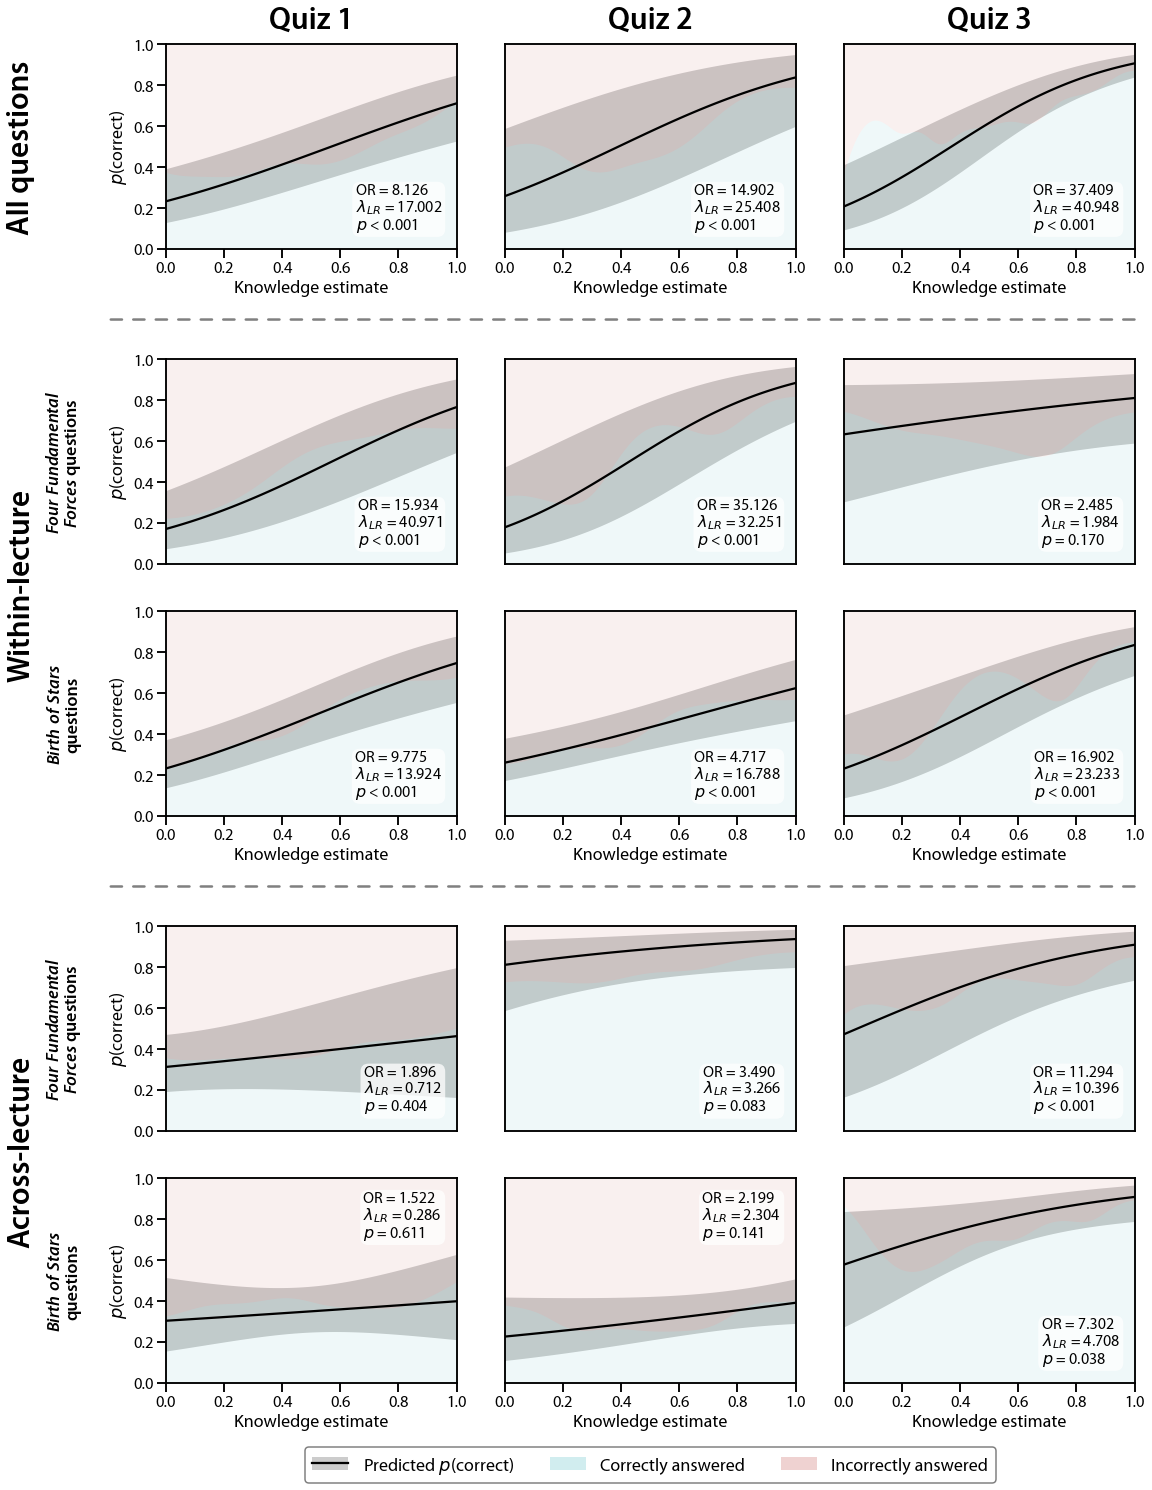

In [27]:
PREDICTION_CURVES_COLOR = 'k'          # color for predicted probability curves
PREDICTION_CIS_ALPHA = 0.2             # opacity for confidence intervals
BG_DENSITY_ALPHA = 0.1                 # opacity for background density plot

STATS_BOX_ALPHA = 0.75                 # opacity for stats annotation bounding box
STATS_BOX_PAD = 0.2                    # padding between stats text and bounding box edge
STATS_BOX_LOCS = {                     # placement options for stats annotation
    'lower right': (0.95, 0.075),
    'upper right': (0.95, 0.69)
}
STATS_UR_AXES = [                      # panels with stats boxes in upper right instead of lower right
    ('quiz2', 'lec2_across'),
    ('quiz1', 'lec2_across')
]

LEGEND_AXES_HEIGHT_RATIO = 0.2         # height of legend axes relative to subplots
LEGEND_DENSITY_HANDLE_ALPHA = 0.3      # opacity for handles for background density plots

SEPLINE_AXES_HEIGHT_RATIO = 0.075      # height of separator line axes relative to subplots
SEPLINE_YAXIS_FRAC = -0.5              # vertical offset of separator line as a fraction of y-axis height
SEPLINE_PATCH_KWARGS = {               # common kwargs for horizontal separator lines
    'xyA': (-0.19, SEPLINE_YAXIS_FRAC), 
    'xyB': (1, SEPLINE_YAXIS_FRAC), 
    'coordsA': 'axes fraction', 
    'coordsB': 'axes fraction',
    'linestyle': (0, (4.5, 4.5)),
    'linewidth': 2.5,
    'color': 'grey'
}

CONDITION_YLABEL_KWARGS = {            # common kwargs for vertical condition labels
    'x': -0.45,
    'fontsize': 'xx-large',
    'fontweight': 'semibold',
    'rotation': 90,
    'horizontalalignment': 'right',
    'verticalalignment': 'center'
}
LECTURE_YLABEL_KWARGS = {              # common kwargs for vertical lecture labels
    'x': -0.35,
    'y': 0.5,
    'fontsize': 'medium',
    'fontweight': 'semibold',
    'linespacing': 1,
    'rotation': 90,
    'horizontalalignment': 'center',
    'verticalalignment': 'center'
}


with sns.plotting_context('talk'):
    
    # ======================= set up axes layout =======================
    
    fig = plt.figure(figsize=(15, 21), tight_layout={'h_pad': 0})
    gs = fig.add_gridspec(8, 3, height_ratios=(
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        LEGEND_AXES_HEIGHT_RATIO
    ))
    
    axes_dict = {
        f'quiz{quiz_n}': {
            cond: fig.add_subplot(gs[row_ix, quiz_n - 1]) 
            for (cond, row_ix) in zip(CONDITIONS, (0, 2, 3, 5, 6)) 
        } 
        for quiz_n in range(1, 4)
    }

    # set reference axes (top left subplot) for controlling all 
    # subplots' x- and y-axes range, styling, etc.
    reference_ax = fig.axes[0]
    for ax in fig.axes[1:]:
        ax.sharex(reference_ax)
        ax.sharey(reference_ax)
        
    reference_ax.set_xlim(0, 1)
    reference_ax.set_ylim(0, 1)
        
    # add axes for separator lines & legend
    sep1_axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 2])]
    sep2_axes = [fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 2])]
    legend_ax = fig.add_subplot(gs[7, :])
    
    # ================= plot observations & model fits =================
    
    for quiz_n in range(1, 4):
        quiz_key = f'quiz{quiz_n}'
        for cond in CONDITIONS:
            ax = axes_dict[quiz_key][cond]
            model = models[quiz_key][cond]['mod']
            predictions_df = models[quiz_key][cond]['predicted_probs']

            # plot predicted probability curve
            ax.plot(predictions_df['x'], 
                    predictions_df['predicted'], 
                    color=PREDICTION_CURVES_COLOR)
            ax.fill_between(x=predictions_df['x'], 
                            y1=predictions_df['conf.low'], 
                            y2=predictions_df['conf.high'],
                            color=PREDICTION_CURVES_COLOR,
                            edgecolor=None,
                            alpha=PREDICTION_CIS_ALPHA)
            
            sns.kdeplot(x=model.coefs.index[1], 
                        data=model.data, 
                        hue='accuracy', 
                        hue_order=('incorrect', 'correct'), 
                        palette=(INCORRECT_ANSWER_COLOR, CORRECT_ANSWER_COLOR),
                        multiple='fill', 
                        alpha=BG_DENSITY_ALPHA, 
                        edgecolor=None, 
                        legend=False,
                        ax=ax)
            
    # ====================== add stats annotation ======================
        
            odds_ratio = np.exp(model.coefs['Estimate'][1])
            lrt_result = models[quiz_key][cond]['lrt'].loc[1, 'Chisq']
            p_val = models[quiz_key][cond]['p_boot']
            
            stats_str = format_stats(odds_ratio, lrt_result, p_val)
            if (quiz_key, cond) in STATS_UR_AXES:
                annot_xy = STATS_BOX_LOCS['upper right']
            else:
                annot_xy = STATS_BOX_LOCS['lower right']
            annotate_textbox(stats_str, 
                             annot_xy=annot_xy, 
                             text_pad=STATS_BOX_PAD,
                             rounded=True,
                             rounding_size=0.5,
                             blur=False,
                             blur_size=0.05,
                             blur_n_steps=10,
                             ax=ax,
                             annot_kwargs={'fontsize': 16, 
                                           'linespacing': 1,
                                           'horizontalalignment': 'right', 
                                           'verticalalignment': 'bottom', 
                                           'multialignment': 'left'},
                             rect_kwargs={'facecolor': 'white', 
                                          'alpha': STATS_BOX_ALPHA})
            
    # ====================== add separator lines =======================
    
    fig.add_artist(ConnectionPatch(axesA=sep1_axes[0], 
                                   axesB=sep1_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    fig.add_artist(ConnectionPatch(axesA=sep2_axes[0], 
                                   axesB=sep2_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    for ax in sep1_axes + sep2_axes:
        ax.axis('off')
        
    # ======================= add shared legend ========================
    
    pred_errband, correct_bg, incorrect_bg = reference_ax.collections
    pred_line2d = reference_ax.lines[0]
    
    leg = legend_ax.legend(handles=((pred_line2d, pred_errband), 
                                    correct_bg, 
                                    incorrect_bg),
                     labels=('Predicted $p$(correct)', 
                             'Correctly answered', 
                             'Incorrectly answered'),
                     loc='lower center',
                     ncol=3,
                     fontsize='medium',
                     edgecolor='grey',
                     framealpha=1,
                     bbox_to_anchor=(0.5, -0.5))
    correct_handle, incorrect_handle = leg.legendHandles[1:]
    correct_handle.set_facecolor((*correct_handle.get_facecolor()[:3], 
                                  LEGEND_DENSITY_HANDLE_ALPHA))
    incorrect_handle.set_facecolor((*incorrect_handle.get_facecolor()[:3], 
                                    LEGEND_DENSITY_HANDLE_ALPHA))

    legend_ax.axis('off')
    
    # ==================== format axes, add labels =====================
        
    for quiz_n in range(1, 4):
        for cond in CONDITIONS:
            ax = axes_dict[f'quiz{quiz_n}'][cond]
            
            if cond.startswith('lec1'):
                ax.xaxis.set_visible(False)
                ax.tick_params(bottom=False, labelbottom=False)
            else:
                ax.set_xlabel('Knowledge estimate')
            
            if quiz_n == 1:
                ax.set_ylabel('$p$(correct)')
            else:
                ax.yaxis.set_visible(False)
                ax.tick_params(left=False, labelleft=False)
            
            if cond == 'all_questions':
                ax.set_title(f'Quiz {quiz_n}', 
                             y=1.05, 
                             fontsize='xx-large', 
                             fontweight='semibold')
                
    fig.text(y=0.5,
             s='All questions',
             transform=axes_dict['quiz1']['all_questions'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Within-lecture',
             transform=axes_dict['quiz1']['lec1_within'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Across-lecture',
             transform=axes_dict['quiz1']['lec1_across'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    
    with (
        disable_logging('matplotlib.font_manager', 'ERROR'), 
        plt.rc_context({
            'mathtext.fontset': 'custom', 
            'mathtext.it': 'sans:semibold:italic'
        })
    ):
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        
#         plt.savefig(FIG_DIR.joinpath('predict-knowledge-questions.pdf'), 
#                     bbox_inches='tight',
#                     dpi=300)
        plt.show()

# Compute 95% CIs for odds ratios for reporting

In [28]:
# # NOTE: like the LRT bootstrapping, this takes a very long time to run 
# # in the Docker container through pymer4, and you may want to run it 
# # on your local machine through R directly in order to parallelize it
# boot_cis_df = pd.DataFrame(columns=('quiz', 'condition', 'ci_low', 'ci_high'))
# pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)
# df_ix = 0
# for quiz_n in range(1, 4):
#     for cond in CONDITIONS:
#         if cond == 'all_questions':
#             parm = 'knowledge_all'
#         elif cond.endswith('within'):
#             parm = 'knowledge_same'
#         else:
#             parm = 'knowledge_other'
            
#         model = models[f'quiz{quiz_n}'][cond]['mod']
#         log_ci_low, log_ci_high = model.confint(parm=[parm], 
#                                                 level=0.95, 
#                                                 method='boot', 
#                                                 nsim=N_BOOTS, 
#                                                 boot_type='basic', 
#                                                 quiet=True, 
#                                                 seed=0).squeeze()
#         boot_cis_df.loc[df_ix] = [f'quiz {quiz_n}', cond, log_ci_low, log_ci_high]
#         df_ix += 1
#         pbar.update()
        
# pbar.close()
# boot_cis_df.to_csv(GLMM_BOOTS_DIR.joinpath('knowledge-coef-bootstrap-cis.csv'), 
#                    index=False)

In [29]:
boot_cis_df = pd.read_csv(GLMM_BOOTS_DIR.joinpath('knowledge-coef-bootstrap-cis.csv'))

for quiz_n in range(1, 4):
    print(f'Quiz {quiz_n}:')
    for cond in CONDITIONS:
        print(f'\t{cond}:')
        model = models[f'quiz{quiz_n}'][cond]['mod']
        odds_ratio = np.exp(model.coefs['Estimate'][1])
        print(f'\t\tOR: {odds_ratio}')
        log_ci_bounds = boot_cis_df.query(
            f'quiz == "quiz {quiz_n}" & condition == "{cond}"'
        )[['ci_low', 'ci_high']].squeeze()
        ci_low, ci_high = np.exp(log_ci_bounds)
        print(f'\t\t95% CI: [{ci_low}, {ci_high}]')

Quiz 1:
	all_questions:
		OR: 8.125844093851807
		95% CI: [3.115986846715646, 20.123421150802496]
	lec1_within:
		OR: 15.934046389582127
		95% CI: [5.1732058345137135, 38.00471601755162]
	lec2_within:
		OR: 9.775425742608158
		95% CI: [2.930138530966126, 25.079503039322976]
	lec1_across:
		OR: 1.895920269013809
		95% CI: [0.41885365783631895, 9.088445517196424]
	lec2_across:
		OR: 1.522091661822706
		95% CI: [0.33244748283654607, 6.835181679435813]
Quiz 2:
	all_questions:
		OR: 14.90219287952224
		95% CI: [4.976334287540299, 39.807328555945205]
	lec1_within:
		OR: 35.126270272357296
		95% CI: [5.112514254694365, 123.86788256789045]
	lec2_within:
		OR: 4.716679198207397
		95% CI: [2.020979822734726, 9.844421065972208]
	lec1_across:
		OR: 3.4898857866688417
		95% CI: [0.7390269668411424, 12.849071679049995]
	lec2_across:
		OR: 2.1985010958390734
		95% CI: [0.7111508402628959, 5.62305142624831]
Quiz 3:
	all_questions:
		OR: 37.4094494243839
		95% CI: [10.424947274834881, 107.1446853535461